In [ ]:
import numpy as np
import os
import torch
import itertools
import sys
from scipy.optimize import linear_sum_assignment

current_dir = os.getcwd()

parent_dir = os.path.dirname(current_dir)

sys.path.append(parent_dir)

from retnet import RetNet,RetNetConfig

def constraint(seq):
    L = len(seq)
    matrix = np.zeros((L, L), dtype=int)

    for i in range(4, L):
        for j in range(i-4):
            base_i = seq[i]
            base_j = seq[j]
            if  ((base_i == 'A' and base_j == 'U') or (base_i == 'U' and base_j == 'A') or
                (base_i == 'C' and base_j == 'G') or (base_i == 'G' and base_j == 'C') or
                (base_i == 'G' and base_j == 'U') or (base_i == 'U' and base_j == 'G') or
                base_i == 'N' or base_j == 'N'):
                matrix[i, j] = 1
    
    return matrix



class outer_concat(torch.nn.Module):
    def __init__(self):
        super(outer_concat, self).__init__()

    def forward(self, x1, x2):
        seq_len = x1.shape[1]
        x1 = x1.unsqueeze(-2).expand(-1, -1, seq_len, -1)
        x2 = x2.unsqueeze(-3).expand(-1, seq_len, -1, -1)
        x = torch.concat((x1,x2),dim=-1)

        return x


class ResNet2DBlock(torch.nn.Module):
    def __init__(self, embed_dim, kernel_size=3, bias=False):
        super().__init__()

        self.conv_net = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=embed_dim, out_channels=embed_dim, kernel_size=1, bias=bias),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=embed_dim, out_channels=embed_dim, kernel_size=kernel_size, bias=bias, padding="same"),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=embed_dim, out_channels=embed_dim, kernel_size=1, bias=bias),
            torch.nn.ReLU()
        )

    def forward(self, x):
        residual = x

        x = self.conv_net(x)
        x = x + residual

        return x
    
class ResNet2D(torch.nn.Module):
    def __init__(self, embed_dim, num_blocks, kernel_size=3, bias=False):
        super().__init__()

        self.blocks = torch.nn.ModuleList(
            [
                ResNet2DBlock(embed_dim, kernel_size, bias=bias) for _ in range(num_blocks)
            ]
        )

    def forward(self, x):
        for block in self.blocks:
            x = block(x)

        return x    
    
class ResNet2D_classifier(torch.nn.Module):
    def __init__(self):
        super(ResNet2D_classifier, self).__init__()
        self.outer_concat = outer_concat()
        self.linear_in = torch.nn.Linear(768,128)
        self.resnet = ResNet2D(128, 16, 3, bias=True)
        self.conv_out = torch.nn.Conv2d(128, 1, kernel_size=3, padding="same")
        

    def forward(self, x):
        x = self.outer_concat(x, x)
        x = self.linear_in(x)
        x = x.permute(0,3,1,2)
        x = self.resnet(x)

        x = self.conv_out(x)
        x = x.squeeze(1)
        
        return x
    
class rnaret_ssp_model(torch.torch.nn.Module): 
    def __init__(self, args):
        super(rnaret_ssp_model, self).__init__()
        self.ret = RetNet(args)
        self.classifier = ResNet2D_classifier()

    def forward(self, x):      
        _,aux  = self.ret(x)
        x = aux['inner_states'][-1]
        x = self.classifier(x)
        return x
    
class post_process(torch.nn.Module):
    def __init__(self):
        super(post_process, self).__init__()
        
    def forward(self, x, mask):
        x = torch.sigmoid(x)
        x = x * mask
        
        sec_struct = torch.where(x > 0.5, torch.ones_like(x), torch.zeros_like(x))
        x = x * sec_struct
        
        B, L, _ = x.shape
        
        for b in range(B):
            tmp = x[b].clone()
            row_ind, col_ind = linear_sum_assignment(-tmp.detach().cpu().numpy())
            binary_matrix = torch.zeros_like(tmp)
            for r, c in zip(row_ind, col_ind):
                binary_matrix[r, c] = 1
                
            sec_struct[b] = binary_matrix

        sec_struct = sec_struct * mask
        
        sec_struct = sec_struct + sec_struct.transpose(1,2)
        
        for b in range(B):
            for i in range(L):
                if torch.sum(sec_struct[b, i, :]) > 1:
                    max_idx = torch.argmax(sec_struct[b, i, :])
                    sec_struct[b, i, :] = 0
                    sec_struct[b, i, max_idx] = 1

                if torch.sum(sec_struct[b, :, i]) > 1:
                    max_idx = torch.argmax(sec_struct[b, :, i])
                    sec_struct[b, :, i] = 0
                    sec_struct[b, max_idx, i] = 1
        
        return sec_struct
        
    
class seq_tokenizer():
    def __init__(self, k=5, max_len=512):
        self.k = k
        self.max_len = max_len
    def tokenize(self, seq):
        kmer_list = np.array([''.join(p) for p in itertools.product('ATCG', repeat=self.k)])
        kmer_to_index = {kmer: idx + 6 for idx, kmer in enumerate(kmer_list)}
        seq = seq.upper()
        seq = seq.replace('U','T')
        seq_len = len(seq)
        
        tokens = np.zeros(self.max_len, dtype=np.int16)
        
        kmers = np.array([seq[i:i+self.k] for i in range(seq_len - self.k + 1)])
        
        indices = np.array([kmer_to_index.get(kmer, 2) for kmer in kmers])
        
        tokens[self.k//2:self.k//2+len(indices)] = indices[:]
        
        tokens[:self.k//2] = 1
        tokens[self.k//2+len(indices):self.k//2+len(indices)+(self.k-1)//2] = 1
        return tokens
    
def parse_bpseq_file(file, max_len=512):
    matrix = np.zeros((max_len, max_len), dtype=np.int8)
    seq = ''

    with open(file, 'r') as f:
        if file.endswith(".bpseq"):
            for line in f:
                parts = line.strip().split()
                idx, nt, pair = parts
                seq = seq + nt

    return seq

In [ ]:
device = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')
batch_size = 1
k = 1
model_config = RetNetConfig(vocab_size=4**k+6,retnet_embed_dim=384, retnet_value_embed_dim=512,
                            retnet_ffn_embed_dim=512,retnet_layers=8,retnet_retention_heads=4,
                            dropout=0.2,activation_dropout=0.2)
model = rnaret_ssp_model(model_config)
post_processor = post_process()

model.load_state_dict(torch.load("../model/ssp/RNAStrAlign_1mer.pth",weights_only=True))
model = model.to(device)
model.eval()

file_path = "../data/archiveII/RNaseP_R.norvegicus.bpseq"
seq_raw = parse_bpseq_file(file_path)
length = len(seq_raw)
seq = seq_tokenizer(k=k,max_len=len(seq_raw)).tokenize(seq_raw)
mask = constraint(seq_raw)
x = torch.tensor(seq).unsqueeze(0).to(torch.int32).to(device)
mask = torch.tensor(mask).unsqueeze(0).to(torch.int32).to(device)

prob = model(x)

pred = post_processor(prob,mask).squeeze(0).detach().cpu().numpy()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def read_bpseq(file_path):
    sequence = []
    pairings = {}
    
    with open(file_path, 'r') as file:
        for line in file:
            fields = line.strip().split()
            if len(fields) != 3:
                continue
            pos, nucleotide, pair_pos = int(fields[0]), fields[1], int(fields[2])
            sequence.append(nucleotide)
            if pair_pos != 0:
                pairings[pos - 1] = pair_pos - 1
    
    return ''.join(sequence), pairings

def build_contact_matrix(sequence, pairings):
    n = len(sequence)
    contact_matrix = np.zeros((n, n), dtype=int)
    
    for i, j in pairings.items():
        contact_matrix[i, j] = 1
        contact_matrix[j, i] = 1
    
    return contact_matrix

def plot_contact_matrix(contact_matrix, sequence=None):

    fig, ax = plt.subplots(figsize=(5, 5))
    cax = ax.imshow(contact_matrix, cmap='Blues',interpolation='nearest') 
    
    plt.title('Ground Truth',fontsize=12)
    plt.show()

sequence, pairings = read_bpseq(file_path)
contact_matrix = build_contact_matrix(sequence, pairings)

In [47]:
m1 = ((prob + prob.transpose(1,2))/2).squeeze(0).detach().cpu().numpy()
m2 = (((torch.sigmoid(prob) + torch.sigmoid(prob).transpose(1,2))/2)).squeeze(0).detach().cpu().numpy()
m3 = pred
m4 = contact_matrix

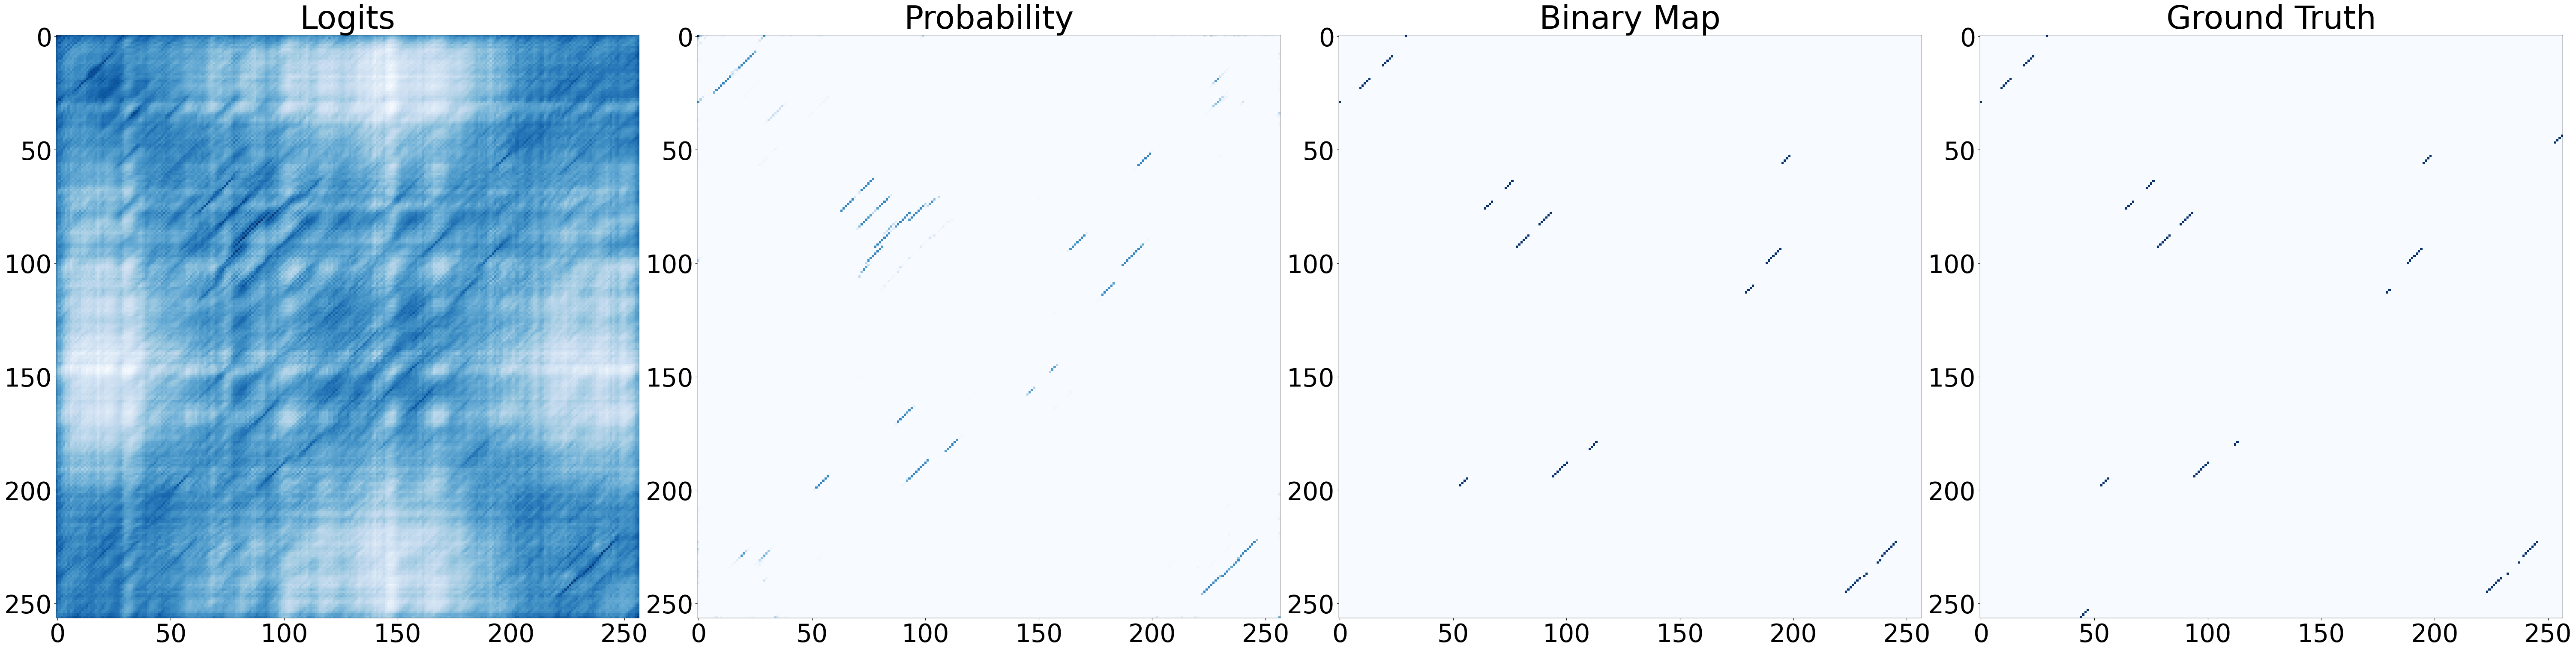

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

cmap = 'Blues'

fig, axes = plt.subplots(1, 4, figsize=(60, 20))

im1 = axes[0].imshow(m1, cmap=cmap, interpolation='nearest')
axes[0].set_title('Logits', fontsize=54)
axes[0].tick_params(axis='both', labelsize=42)

im2 = axes[1].imshow(m2, cmap=cmap, interpolation='nearest')
axes[1].set_title('Probability', fontsize=54)
axes[1].tick_params(axis='both', labelsize=42)

im3 = axes[2].imshow(m3, cmap=cmap, interpolation='nearest')
axes[2].set_title('Binary Map', fontsize=54)
axes[2].tick_params(axis='both', labelsize=42)

im4 = axes[3].imshow(m4, cmap=cmap, interpolation='nearest')
axes[3].set_title('Ground Truth', fontsize=54)
axes[3].tick_params(axis='both', labelsize=42)
for spine in axes[0].spines.values():
    spine.set_linewidth(0.3)
for spine in axes[1].spines.values():
    spine.set_linewidth(0.3)
for spine in axes[2].spines.values():
    spine.set_linewidth(0.3)
for spine in axes[3].spines.values():
    spine.set_linewidth(0.3)

plt.tight_layout()
plt.savefig("RNaseP_R.norvegicus.pdf", format='pdf',bbox_inches='tight')